In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:

# Set up data transformations (including normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion MNIST dataset
fashion_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



100%|██████████| 26421880/26421880 [00:02<00:00, 11904799.43it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 243827.03it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 855627.38it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23495404.78it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
def flatten_data(dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    return images.view(images.size(0), -1), labels

fashion_train_images, fashion_train_labels = flatten_data(fashion_trainset)
fashion_test_images, fashion_test_labels = flatten_data(fashion_testset)


In [4]:
fashion_train_images = fashion_train_images.reshape(-1, 28*28)
fashion_test_images = fashion_test_images.reshape(-1, 28*28)

In [5]:
# Convert torch tensors to numpy
X_train = fashion_train_images.numpy()
X_test = fashion_test_images.numpy()
y_train_labels = fashion_train_labels.numpy()
y_test_labels = fashion_test_labels.numpy()

# One-hot encoding of labels
y_train = np.eye(10)[y_train_labels]
y_test = np.eye(10)[y_test_labels]

In [ ]:
y_train.shape

(60000, 10)

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
X_train.shape

(60000, 784)

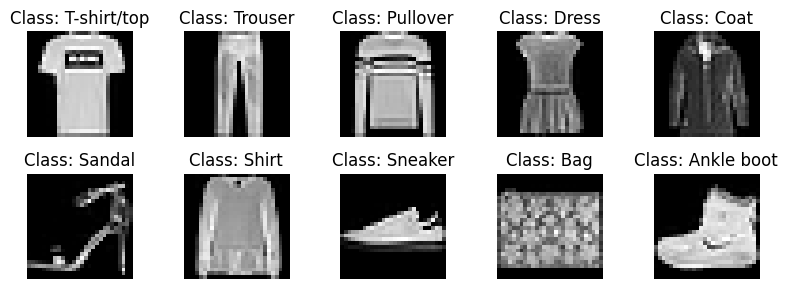

In [7]:
class_labels_dict = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
                     5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

fig = plt.figure(figsize=(8, 3))

# Convert one-hot encoded y_train back to integer labels for filtering
y_train_labels = np.argmax(y_train, axis=1)

for i in range(10):
    plt.subplot(2, 5, i+1)

    # Reshape the image from (784,) to (28, 28)
    img = X_train[y_train_labels == i][0].reshape(28, 28)

    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Class: {}".format(class_labels_dict[i]))
    plt.axis('off')

plt.tight_layout()
plt.show()


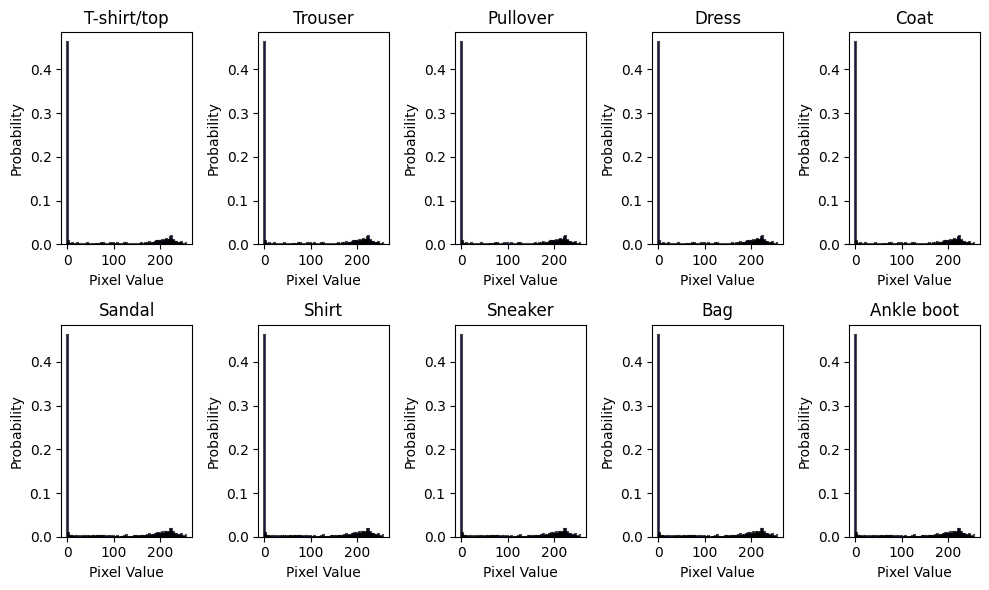

In [10]:
# Plot pixel distribution for each class
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    class_mask = (fashion_trainset[1] == i)
    class_images = (fashion_trainset[0][class_mask] * 0.5 + 0.5) * 255.0
    pixel_values = class_images.ravel()  # Flatten all images of this class
    plt.hist(pixel_values, bins=255, density=True, color='blue', alpha=0.7, linewidth=1.5, edgecolor='black')
    plt.title(class_labels_dict[i])
    plt.xlabel('Pixel Value')
    plt.ylabel('Probability')
    plt.tight_layout()

plt.show()

In [11]:
class MLP:
    def __init__(self, hidden_layers, activation_function='relu', initialization='gaussian',
                 l1_lambda=0, l2_lambda=0):
        self.hidden_layers = hidden_layers
        self.activation_function = activation_function
        self.weights = []
        self.biases = []
        self.activations = []

        # Regularization parameters
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # Weight and Bias Initialization
        input_size = 28*28
        for units in hidden_layers:
            self.weights.append(self.initialize_weights(input_size, units, initialization))
            self.biases.append(np.zeros((1, units)))
            input_size = units
        self.weights.append(self.initialize_weights(input_size, 10, initialization))
        self.biases.append(np.zeros((1, 10)))


    # New method for weight initialization
    def initialize_weights(self, size_in, size_out, method):
        if method == 'zeros':
            return np.zeros((size_in, size_out))
        elif method == 'uniform':
            return np.random.uniform(-1, 1, (size_in, size_out))
        elif method == 'gaussian':
            return np.random.randn(size_in, size_out)
        elif method == 'xavier':
            return np.random.randn(size_in, size_out) / np.sqrt(size_in)
        elif method == 'kaiming':
            return np.random.randn(size_in, size_out) * np.sqrt(2. / size_in)
        else:
            raise ValueError(f"Unknown initialization method: {method}")

    def activation(self, z):
        if self.activation_function == 'relu':
            return np.maximum(0, z)
        elif self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation_function == 'tanh':
            return np.tanh(z)
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def activation_derivative(self, z):
        if self.activation_function == 'relu':
            return (z > 0).astype(float)
        elif self.activation_function == 'sigmoid':
            sigmoid_val = self.activation(z)
            return sigmoid_val * (1 - sigmoid_val)
        elif self.activation_function == 'tanh':
            tanh_val = self.activation(z)
            return 1.0 - tanh_val**2
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        log_probs = -np.log(y_pred[np.arange(n_samples), y_true.argmax(axis=1)])
        cross_entropy = np.sum(log_probs) / n_samples

        # Regularization
        l1_loss = self.l1_lambda * sum([np.sum(np.abs(w)) for w in self.weights])
        l2_loss = self.l2_lambda * sum([np.sum(w**2) for w in self.weights])

        return cross_entropy + l1_loss + l2_loss

    def forward_pass(self, X):
        self.activations = [X]
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.activations.append(self.activation(z))
        z_out = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.activations.append(self.softmax(z_out))
        return self.activations[-1]

    def backward_pass(self, X, y, learning_rate):
        m = X.shape[0]
        dz = self.activations[-1] - y
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.activations[i].T, dz) / m
            db = np.sum(dz, axis=0) / m

            # Incorporate L1 and L2 regularization into the weight updates
            dw += self.l1_lambda * np.sign(self.weights[i]) / m + self.l2_lambda * self.weights[i] / m

            if i != 0:
                dz = np.dot(dz, self.weights[i].T) * self.activation_derivative(self.activations[i])

            self.weights[i] -= learning_rate * dw
            self.biases[i] -= learning_rate * db



    def fit(self, X, y, learning_rate=0.01, epochs=100, batch_size=64):
        for epoch in range(epochs):
            idx = np.random.permutation(X.shape[0])
            X_shuffled = X[idx]
            y_shuffled = y[idx]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                self.forward_pass(X_batch)
                self.backward_pass(X_batch, y_batch, learning_rate)

    def predict(self, X):
        predictions = self.forward_pass(X)
        return np.argmax(predictions, axis=1)


In [ ]:
def evaluate_acc(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = y_true.shape[0]
    return correct_predictions / total_predictions

### Base Case (if needed)


In [ ]:
# Create MLP instance and train
mlp = MLP(hidden_layers=[128, 128], activation_function='relu', initialization='kaiming')
mlp.fit(X_train, y_train, learning_rate=0.01, epochs=100)

# Predict and evaluate
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)

print("Training Accuracy:", evaluate_acc(y_train_labels, y_pred_train))
print("Test Accuracy:", evaluate_acc(y_test_labels, y_pred_test))


Training Accuracy: 0.9741833333333333
Test Accuracy: 0.8829


#Task 3: Run the experiments

### 3.1 Implementations with different weight initializations

In [ ]:
# Training the model with different weight initializations

initialization_methods = ['zeros', 'uniform', 'gaussian', 'xavier', 'kaiming']
test_accuracies, train_accuracies = {}, {}

for init_method in initialization_methods:
    mlp = MLP(hidden_layers=[128], initialization=init_method)
    mlp.fit(X_train, y_train, epochs=100, learning_rate=0.01)

    y_pred_test = mlp.predict(X_test)
    y_pred_train = mlp.predict(X_train)
    train_accuracy = evaluate_acc(y_train_labels, y_pred_train)
    test_accuracy = evaluate_acc(y_test_labels, y_pred_test)
    test_accuracies[init_method] = test_accuracy
    train_accuracies[init_method] = train_accuracy

print(test_accuracies)
print(train_accuracies)

{'zeros': 0.1, 'uniform': 0.8369, 'gaussian': 0.7825, 'xavier': 0.8835, 'kaiming': 0.8826}
{'zeros': 0.1, 'uniform': 0.86725, 'gaussian': 0.8058666666666666, 'xavier': 0.95065, 'kaiming': 0.9487833333333333}


### 3.2 Implementations with different numbers of hidden layers

In [ ]:
# No Hidden Layer (Logistic Regression):
mlp_no_hidden = MLP(hidden_layers=[], activation_function='relu', initialization='kaiming')
mlp_no_hidden.fit(X_train, y_train, epochs=100, learning_rate=0.01)

In [ ]:
# One Hidden Layer with 128 Units:
mlp_single_hidden = MLP(hidden_layers=[128], activation_function='relu', initialization='kaiming')
mlp_single_hidden.fit(X_train, y_train, epochs=100, learning_rate=0.01)

In [ ]:
# Two Hidden Layers each with 128 Units:
mlp_double_hidden = MLP(hidden_layers=[128, 128], activation_function='relu', initialization='kaiming')
mlp_double_hidden.fit(X_train, y_train, epochs=100, learning_rate=0.01)

In [ ]:
test_accuracy_double_hidden = evaluate_acc(y_test_labels, mlp_double_hidden.predict(X_test))
train_accuracy_double_hidden = evaluate_acc(y_train_labels, mlp_double_hidden.predict(X_train))
print(f"Test Accuracy (Two Hidden Layers): {test_accuracy_double_hidden:.4f}")
print(f"Train Accuracy (Two Hidden Layers): {train_accuracy_double_hidden:.4f}")

test_accuracy_no_hidden = evaluate_acc(y_test_labels, mlp_no_hidden.predict(X_test))
train_accuracy_no_hidden = evaluate_acc(y_train_labels, mlp_no_hidden.predict(X_train))
print(f"Test Accuracy (No Hidden Layer): {test_accuracy_no_hidden:.4f}")
print(f"Train Accuracy (No Hidden Layers): {train_accuracy_no_hidden:.4f}")

test_accuracy_single_hidden = evaluate_acc(y_test_labels, mlp_single_hidden.predict(X_test))
train_accuracy_single_hidden = evaluate_acc(y_train_labels, mlp_single_hidden.predict(X_train))
print(f"Test Accuracy (Single Hidden Layer): {test_accuracy_single_hidden:.4f}")
print(f"Train Accuracy (Single Hidden Layers): {train_accuracy_single_hidden:.4f}")

Test Accuracy (Two Hidden Layers): 0.8833
Train Accuracy (Two Hidden Layers): 0.9713
Test Accuracy (No Hidden Layer): 0.8436
Train Accuracy (No Hidden Layers): 0.8724
Test Accuracy (Single Hidden Layer): 0.8870
Train Accuracy (Single Hidden Layers): 0.9510


### 3.3 Implementations with different activations

In [ ]:
activation_functions = ['relu', 'sigmoid', 'tanh']
initializations = ['kaiming', 'xavier', 'xavier']

accuracies = {}
for i in range(len(initializations)):
    mlp = MLP(hidden_layers=[128, 128], activation_function=activation_functions[i], initialization=initializations[i])
    mlp.fit(X_train, y_train, learning_rate=0.01, epochs=100)
    y_pred_test = mlp.predict(X_test)
    y_pred_train = mlp.predict(X_train)
    test_accuracy = evaluate_acc(y_test_labels, y_pred_test)
    train_accuracy = evaluate_acc(y_train_labels, y_pred_train)
    accuracies[activation_functions[i]] = [test_accuracy]
    accuracies[activation_functions[i]].append(train_accuracy)

for act_func, acc in accuracies.items():
    print(f"Test Accuracy with {act_func} activation: {acc[0]:.4f}")
    print(f"Train Accuracy with {act_func} activation: {acc[1]:.4f}")


Test Accuracy with relu activation: 0.8766
Train Accuracy with relu activation: 0.9624
Test Accuracy with sigmoid activation: 0.8378
Train Accuracy with sigmoid activation: 0.8554
Test Accuracy with tanh activation: 0.8814
Train Accuracy with tanh activation: 0.9394


### 3.4 Implementations with L1 and L2 regularization

In [ ]:
# Without regularization
mlp_no_reg = MLP(hidden_layers=[128, 128], activation_function='relu', initialization='kaiming')
mlp_no_reg.fit(X_train, y_train, learning_rate=0.01, epochs=100)
test_accuracy_no_reg = evaluate_acc(y_test_labels, mlp_no_reg.predict(X_test))
train_accuracy_no_reg = evaluate_acc(y_train_labels, mlp_no_reg.predict(X_train))
print(f"Test Accuracy without regularization: {test_accuracy_no_reg:.4f}")
print(f"Train Accuracy without regularization: {train_accuracy_no_reg:.4f}")

# With L1 regularization
mlp_l1 = MLP(hidden_layers=[128, 128], l1_lambda=0.001, activation_function='relu', initialization='kaiming')
mlp_l1.fit(X_train, y_train, learning_rate=0.01, epochs=100)
test_accuracy_l1 = evaluate_acc(y_test_labels, mlp_l1.predict(X_test))
train_accuracy_l1 = evaluate_acc(y_train_labels, mlp_l1.predict(X_train))
print(f"Test Accuracy with L1 regularization: {test_accuracy_l1:.4f}")
print(f"Train Accuracy with L1 regularization: {train_accuracy_l1:.4f}")

# With L2 regularization
mlp_l2 = MLP(hidden_layers=[128, 128], l2_lambda=0.001, activation_function='relu', initialization='kaiming')
mlp_l2.fit(X_train, y_train, learning_rate=0.01, epochs=100)
test_accuracy_l2 = evaluate_acc(y_test_labels, mlp_l2.predict(X_test))
train_accuracy_l2 = evaluate_acc(y_train_labels, mlp_l2.predict(X_train))
print(f"Test Accuracy with L2 regularization: {test_accuracy_l2:.4f}")
print(f"Train Accuracy with L2 regularization: {train_accuracy_l2:.4f}")


Test Accuracy without regularization: 0.8739
Train Accuracy without regularization: 0.9519
Test Accuracy with L1 regularization: 0.8836
Train Accuracy with L1 regularization: 0.9649
Test Accuracy with L2 regularization: 0.8867
Train Accuracy with L2 regularization: 0.9773


In [ ]:
mlp_l1l2 = MLP(hidden_layers=[128, 128], l1_lambda=0.001, l2_lambda=0.001, activation_function='relu', initialization='kaiming')
mlp_l1l2.fit(X_train, y_train, learning_rate=0.01, epochs=100)
test_accuracy_l1l2 = evaluate_acc(y_test_labels, mlp_l1l2.predict(X_test))
train_accuracy_l1l2 = evaluate_acc(y_train_labels, mlp_l1l2.predict(X_train))
print(f"Test Accuracy with L1 and L2 regularization: {test_accuracy_l1l2:.4f}")
print(f"Train Accuracy with L1 and L2 regularization: {train_accuracy_l1l2:.4f}")

Test Accuracy with L1 and L2 regularization: 0.8863
Train Accuracy with L1 and L2 regularization: 0.9715


### 3.5 Implementations with unnormalized training data

In [ ]:
# Load the Fashion MNIST dataset without normalization
fashion_trainset_unnorm = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
fashion_testset_unnorm = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

fashion_train_images_unnorm, fashion_train_labels_unnorm = flatten_data(fashion_trainset_unnorm)
fashion_test_images_unnorm, fashion_test_labels_unnorm = flatten_data(fashion_testset_unnorm)

fashion_train_images_unnorm = fashion_train_images_unnorm.reshape(-1, 28*28)
fashion_test_images_unnorm = fashion_test_images_unnorm.reshape(-1, 28*28)

# Convert torch tensors to numpy
X_train_unnorm = fashion_train_images_unnorm.numpy()
X_test_unnorm = fashion_test_images_unnorm.numpy()
y_train_labels_unnorm = fashion_train_labels_unnorm.numpy()
y_test_labels_unnorm = fashion_test_labels_unnorm.numpy()

# One-hot encoding of labels
y_train_unnorm = np.eye(10)[y_train_labels_unnorm]
y_test_unnorm = np.eye(10)[y_test_labels_unnorm]


In [ ]:
mlp_unnorm = MLP(hidden_layers=[128, 128], activation_function='relu', initialization='kaiming')
mlp_unnorm.fit(X_train_unnorm, y_train_unnorm, learning_rate=0.01, epochs=10)
test_accuracy_unnorm = evaluate_acc(y_test_labels_unnorm, mlp_unnorm.predict(X_test_unnorm))
train_accuracy_unnorm = evaluate_acc(y_train_labels_unnorm, mlp_unnorm.predict(X_train_unnorm))
print(f"Test Accuracy with unnormalized data: {test_accuracy_unnorm:.4f}")
print(f"Train Accuracy with unnormalized data: {train_accuracy_unnorm:.4f}")


Test Accuracy with unnormalized data: 0.8505
Train Accuracy with unnormalized data: 0.8690
